In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('/sbnd/app/users/brindenc/mypython')
from bc_utils.pmtutils import plotters as pmtplotters
from bc_utils.pmtutils import pic as pmtpic
from bc_utils.utils import plotters,pic

%load_ext autoreload
%autoreload 2

In [2]:
pmts = pd.read_pickle('data/PMT_info.pkl')
pmts = pmts.drop(['f','distance','opdet_area'],axis=1)
#pmts.columns
#106.525,97.126

In [3]:
#I need to change 2nd character 1 <--> 3
# channel_mapping = pmtpic.channel_mapping
# for key in channel_mapping:
#   if key%2 == 1:
#     print(key,key%2)
#   #if 7 == 7:
#     s = list(channel_mapping[key][1]) #2nd string
#     if s[2] == '3':
#       s[2] = '1'
#     elif s[2] == '1':
#       s[2] = '3'
#     channel_mapping[key][1] = "".join(s)
# channel_mapping[6],channel_mapping[7]


In [4]:
#Constants [cm]
cabletray_to_flange = 160
lift_above_flange = 50
depth = 30 #Depth from tray to flange
#depth = 0 #Depth from tray to flange
tray_to_exit = 15 #Cable tray to exit point from APA

method = 0 #From PMT directly to exit
#method = 1 #From PMT across bar, up side 
#method = 2 #From Cable tray directly to bottom of flange

#Cable tray coordinates
boxes_1_6_cabletray = [125,200+tray_to_exit]
boxes_7_12_cabletray = [375,200+tray_to_exit]
boxes_13_18_cabletray=boxes_1_6_cabletray
boxes_19_24_cabletray=boxes_7_12_cabletray

#Entrance to flange tube coordinates
#Flanges are on opposite sides for opposite flanges
flange_drop_loc0 = np.add(boxes_1_6_cabletray,[190,0])
flange_drop_loc1 = np.add(boxes_13_18_cabletray,[60,0])

#Flange loc
flange_loc0 = np.add(flange_drop_loc0,[0,cabletray_to_flange+lift_above_flange])
flange_loc1 = np.add(flange_drop_loc1,[0,cabletray_to_flange+lift_above_flange])

In [5]:
box_bounds0 ={
  1:[[0,125],[200,62.5],[125,200]],
  2:[[0,125],[62.5,-62.5],[125,62.5]],
  3:[[0,125],[-62.5,-200],[125,-62.5]],
  4:[[125,250],[200,62.5],[125,200]],
  5:[[125,250],[62.5,-62.5],[125,62.5]],
  6:[[125,250],[-62.5,-200],[125,-62.5]],
  7:[[250,375],[200,62.5],[375,200]],
  8:[[250,375],[62.5,-62.5],[375,62.5]],
  9:[[250,375],[-62.5,-200],[375,-62.5]],
  10:[[375,500],[200,62.5],[375,200]],
  11:[[375,500],[62.5,-62.5],[375,62.5]],
  12:[[375,500],[-62.5,-200],[375,-62.5]]
}
box_bounds1 ={
  13:[[0,125],[200,62.5],[125,200]],
  14:[[0,125],[62.5,-62.5],[125,62.5]],
  15:[[0,125],[-62.5,-200],[125,-62.5]],
  16:[[125,250],[200,62.5],[125,200]],
  17:[[125,250],[62.5,-62.5],[125,62.5]],
  18:[[125,250],[-62.5,-200],[125,-62.5]],
  19:[[250,375],[200,62.5],[375,200]],
  20:[[250,375],[62.5,-62.5],[375,62.5]],
  21:[[250,375],[-62.5,-200],[375,-62.5]],
  22:[[375,500],[200,62.5],[375,200]],
  23:[[375,500],[62.5,-62.5],[375,62.5]],
  24:[[375,500],[-62.5,-200],[375,-62.5]]
}
for box,bounds in box_bounds0.items():
  print(box,bounds)

1 [[0, 125], [200, 62.5], [125, 200]]
2 [[0, 125], [62.5, -62.5], [125, 62.5]]
3 [[0, 125], [-62.5, -200], [125, -62.5]]
4 [[125, 250], [200, 62.5], [125, 200]]
5 [[125, 250], [62.5, -62.5], [125, 62.5]]
6 [[125, 250], [-62.5, -200], [125, -62.5]]
7 [[250, 375], [200, 62.5], [375, 200]]
8 [[250, 375], [62.5, -62.5], [375, 62.5]]
9 [[250, 375], [-62.5, -200], [375, -62.5]]
10 [[375, 500], [200, 62.5], [375, 200]]
11 [[375, 500], [62.5, -62.5], [375, 62.5]]
12 [[375, 500], [-62.5, -200], [375, -62.5]]


In [6]:
min_cable_length = 800 #A little below for wiggle room

In [7]:
for line,row in pmts.iterrows():
  x = row['ophit_opdet_x']
  y = row['ophit_opdet_y']
  z = row['ophit_opdet_z']
  tpc = row['opdet_tpc']
  if tpc == 0:
    box_bounds = box_bounds0
    flange_drop_loc = flange_drop_loc0
  else:
    box_bounds = box_bounds1
    flange_drop_loc = flange_drop_loc1
  for box,bounds in box_bounds.items():
    ybounds = bounds[1]
    zbounds = bounds[0]

    if y < ybounds[0] and y > ybounds[1]:
      if z > zbounds[0] and z < zbounds[1]:
        box_label = pmtpic.channel_mapping[line][0] #Box letter
        exit_pointy = bounds[2][1]
        exit_pointz = bounds[2][0]
        pmts.loc[line,'box'] = box
        if method == 0:
          pmts.loc[line,'d_to_exit'] = np.sqrt((y-exit_pointy)**2+(z-exit_pointz)**2)
        elif method == 1:
          pmts.loc[line,'d_to_exit'] = abs(y-exit_pointy)+abs(z-exit_pointz)
        pmts.loc[line,'exit_pointz'] = exit_pointz
        pmts.loc[line,'exit_pointy'] = exit_pointy
        if box >=1 and box <=6:
          boxes_cabletray = boxes_1_6_cabletray
        elif box >=7 and box <=12:
          boxes_cabletray = boxes_7_12_cabletray
        elif box >=13 and box <=18:
          boxes_cabletray = boxes_13_18_cabletray
        elif box >=19 and box <=24:
          boxes_cabletray = boxes_19_24_cabletray
        #print(boxes_cabletray,box)
        pmts.loc[line,'cable_pointz'] = boxes_cabletray[0]
        pmts.loc[line,'cable_pointy'] = boxes_cabletray[1]
        pmts.loc[line,'d_to_cabletray'] = abs(boxes_cabletray[1]-exit_pointy)
        if box_label in ['C','F','R','O']:
          #print(box_label)
          pmts.loc[line,'d_to_flangedrop'] =abs(flange_drop_loc[0]-boxes_cabletray[0])
        else:
          pmts.loc[line,'d_to_flangedrop'] =abs(flange_drop_loc[0]-boxes_cabletray[0])+depth
        pmts.loc[line,'d_to_flange'] = cabletray_to_flange+lift_above_flange
        pmts.loc[line,'installation_channel'] = pmtpic.channel_mapping[line][1]
        pmts.loc[line,'installation_box'] = box_label
pmts.loc[:,'cable_distance'] = pmts.loc[:,'d_to_exit']+pmts.loc[:,'d_to_cabletray']+pmts.loc[:,'d_to_flangedrop']+pmts.loc[:,'d_to_flange']
  
for line,row in pmts.iterrows():
  if row['cable_distance'] > min_cable_length:
    pmts.loc[line,'too_short'] = 1
  else:
    pmts.loc[line,'too_short'] = 0


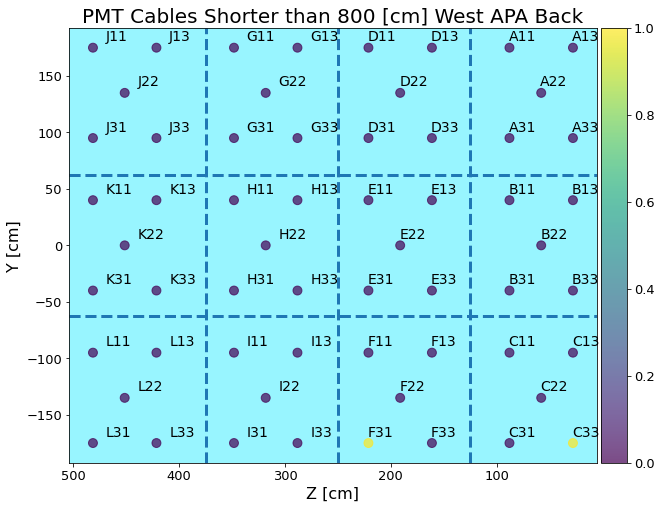

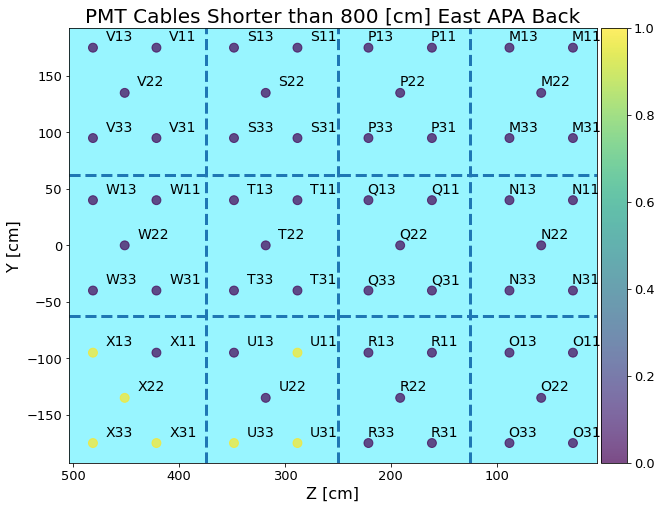

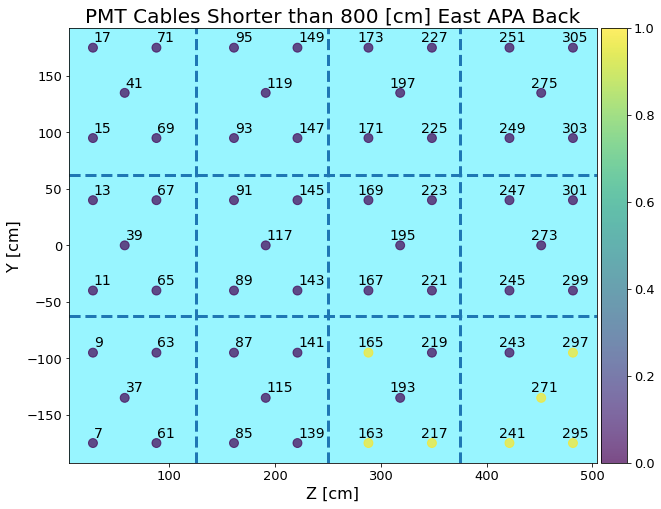

In [9]:
fig,ax = pmtplotters.plot_TPC(0,'too_short',f'PMT Cables Shorter than {min_cable_length} [cm]',
pmts,det_key='installation_channel',mark_borders=False,make_colorbar=True,label_channels=True,
invert_xaxis=True)
fig,ax = pmtplotters.plot_TPC(1,'too_short',f'PMT Cables Shorter than {min_cable_length} [cm]',
pmts,det_key='installation_channel',mark_borders=False,make_colorbar=True,label_channels=True,
invert_xaxis=True)
fig,ax = pmtplotters.plot_TPC(1,'too_short',f'PMT Cables Shorter than {min_cable_length} [cm]',
pmts,mark_borders=False,make_colorbar=True,label_channels=True,
invert_xaxis=False)

In [10]:
#ch = 6
for ch in list(pmts.index):
  tpc = ch%2
  if tpc == 0:
    invert_xaxis=True
  elif tpc == 1:
    invert_xaxis=True
  fig,ax = pmtplotters.plot_TPC(tpc,'box',f'Ch {pmts.loc[ch,"installation_channel"]} Box: {pmts.loc[ch,"installation_box"]}\n Cable Distance = {int(pmts.loc[ch,"cable_distance"])} cm',
  pmts,det_key='installation_channel',mark_borders=True,make_colorbar=False,invert_xaxis=invert_xaxis)
  # fig,ax = pmtplotters.plot_TPC(tpc,'too_short',f'PMT Cables Shorter than {min_cable_length} [cm]',
  # pmts,det_key='ophit_opdet',mark_borders=True,make_colorbar=True)
  # fig,ax = pmtplotters.plot_TPC(tpc,'cable_distance',f'PMT to Flange Cable Distances [m]',
  # pmts,det_key='ophit_opdet',mark_borders=True,make_colorbar=True)
  if tpc == 0:
    flange_drop_loc = flange_drop_loc0
    flange_loc = flange_loc0
  if tpc == 1:
    flange_drop_loc = flange_drop_loc1
    flange_loc = flange_loc1

  x = pmts.loc[ch,'ophit_opdet_x']
  y = pmts.loc[ch,'ophit_opdet_y']
  z = pmts.loc[ch,'ophit_opdet_z']
  exity = pmts.loc[ch,'exit_pointy']
  exitz = pmts.loc[ch,'exit_pointz']
  cabley = pmts.loc[ch,'cable_pointy']
  cablez = pmts.loc[ch,'cable_pointz']
  #print(exitz,exity,z,y)
  #print(flange_drop_loc,flange_loc)
  ax.scatter(flange_loc[0],flange_loc[1],s=300,c='black',zorder=1)
  ax.text(flange_loc[0]+15,flange_loc[1],'Flange',fontsize=20)
  if method == 0:
    ax.plot([z,exitz],[y,exity],c='r',linewidth=5)
  elif method == 1:
    ax.plot([z,exitz],[y,y],c='r',linewidth=5)
    ax.plot([exitz,exitz],[y,exity],c='r',linewidth=5)
  ax.plot([exitz,cablez],[exity,cabley],c='r',linewidth=5)
  ax.plot([cablez,flange_drop_loc[0]],[cabley,flange_drop_loc[1]],c='r',linewidth=5)
  ax.plot([flange_drop_loc[0],flange_loc[0]],[flange_drop_loc[1],flange_loc[1]],c='r',linewidth=5,zorder=-1)
  plotters.save_plot(f'ch_{ch}_cablepath_method{method}')
  plt.close()
  #print(ch)


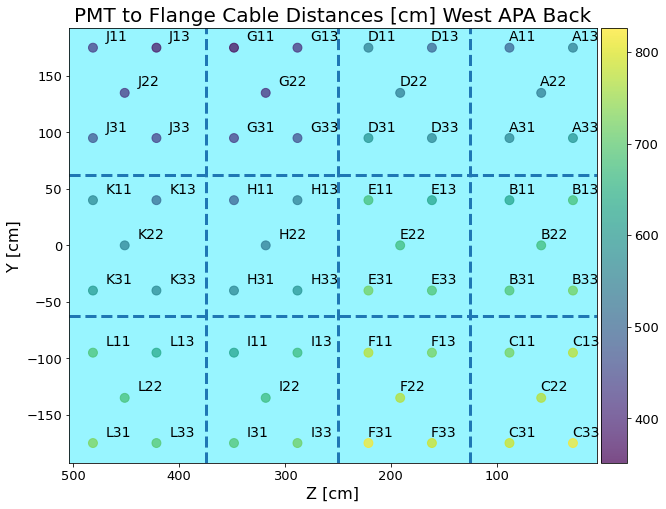

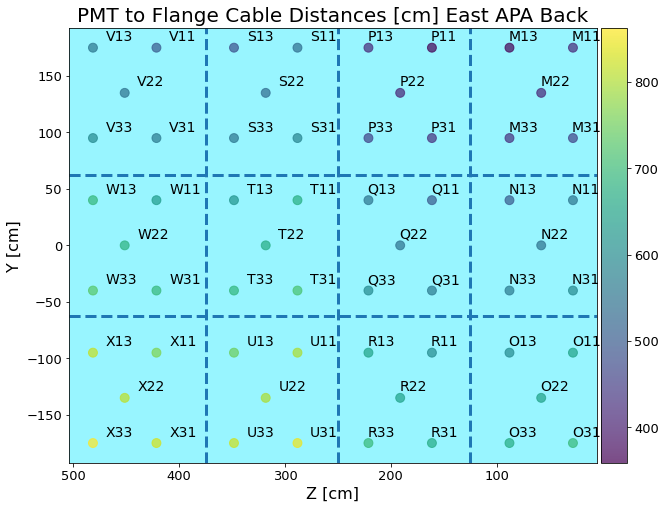

In [11]:
fig,ax = pmtplotters.plot_TPC(0,'cable_distance',f'PMT to Flange Cable Distances [cm]',
pmts,mark_borders=False,make_colorbar=True,invert_xaxis=True,det_key='installation_channel')
plotters.save_plot(f'tpc0_cable_length_method{method}')
fig,ax = pmtplotters.plot_TPC(1,'cable_distance',f'PMT to Flange Cable Distances [cm]',
pmts,mark_borders=False,invert_xaxis=True,make_colorbar=True,det_key='installation_channel')
plotters.save_plot(f'tpc1_cable_length_method{method}')

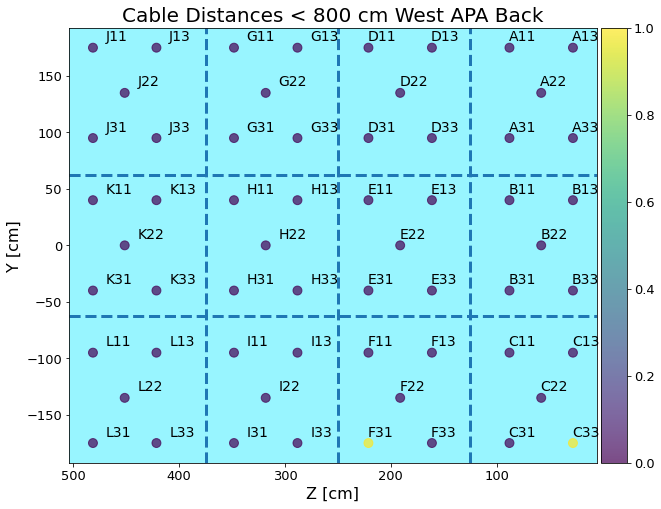

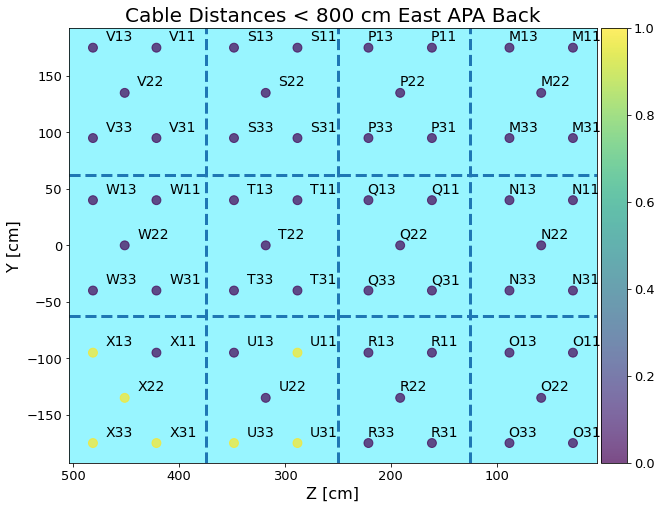

In [12]:
fig,ax = pmtplotters.plot_TPC(0,'too_short',f'Cable Distances < {min_cable_length} cm',
pmts,det_key='installation_channel',mark_borders=False,make_colorbar=True,invert_xaxis=True)
plotters.save_plot(f'tpc0_too_short{method}')
fig,ax = pmtplotters.plot_TPC(1,'too_short',f'Cable Distances < {min_cable_length} cm',
pmts,det_key='installation_channel',mark_borders=False,invert_xaxis=True,make_colorbar=True)
plotters.save_plot(f'tpc1_too_short{method}')

In [13]:
save_keys = ['ophit_opdet', 'ophit_opdet_x', 'ophit_opdet_y', 'ophit_opdet_z',
            'd_to_exit','d_to_cabletray',
       'd_to_flangedrop', 'd_to_flange', 'installation_channel',
       'installation_box', 'cable_distance']
save_pmts = pmts.loc[:,save_keys]
save_pmts.to_csv('data/pmt_cabling.csv')

In [21]:
pmts.columns


Index(['ophit_opdet', 'ophit_opdet_x', 'ophit_opdet_y', 'ophit_opdet_z',
       'ophit_opdet_type', 'opdet_tpc', 'box', 'd_to_exit', 'exit_pointz',
       'exit_pointy', 'cable_pointz', 'cable_pointy', 'd_to_cabletray',
       'd_to_flangedrop', 'd_to_flange', 'installation_channel',
       'installation_box', 'cable_distance', 'too_short'],
      dtype='object')